## VAEs - Normalizing Flow Prior

In this notebook we train the VAE with NFP and inspect its training behaviour.

### Objective

We are still focusing on the elbo, the only difference from the previous derivation is that now we have to rewrite it so we dont have the standard normal prior, but instead the flow network. The overall training mechanics do not change apart from having this additional learnable hidden density where we previously placed the standard gaussian.

In [1]:
import torch
from IPython import display
from tqdm import tqdm
from torch import nn, optim
from torch.autograd.variable import Variable
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams["figure.figsize"] = (15, 7.5)
%config InlineBackend.figure_format='retina'

In [2]:
from training_tools import load_data, imshow, n_params
from myVAES import CNNEncoder, Encoder, EncoderNO2, Decoder, FlowPrior, Encoder3, Decoder3
from fid_score import FID, FID2

## A) MNIST

In [42]:
dataset = {0 : "mnist", 1 : "svhn"}[0]
encoder_type = "dense"
eval_fid = False
latent_dim = D = 50
M = 277
lr = 0.00025
batch_size = 100
num_epochs = 50
input_shape = {"mnist" : (batch_size, 1,28,28),
               "svhn"  : (batch_size, 3,32,32)}[dataset]
expected_input_shape = (input_shape[0],
                        input_shape[1] * input_shape[2] * input_shape[3])

# parameter approximator for q(z|x)
encoder = Encoder(expected_input_shape[-1], M, latent_dim).cuda()
# parameter approximator for p(x|z)
decoder = Decoder(latent_dim, M, expected_input_shape[-1]).cuda()
# prior p(z|x)
num_flows = 2
nets = lambda: nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                             nn.Linear(M, M), nn.LeakyReLU(),
                             nn.Linear(M, D // 2), nn.Tanh())

nett = lambda: nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                             nn.Linear(M, M), nn.LeakyReLU(),
                             nn.Linear(M, D // 2))

p = FlowPrior(nets, nett, num_flows, D).cuda()

In [17]:
n_params(encoder) + n_params(decoder) + n_params(p)

995969

In [5]:
X_, V_ = load_data(dataset, test=False, val_frac = .1)
N = X_.shape[0]
if N%batch_size:
    N = N - N%batch_size

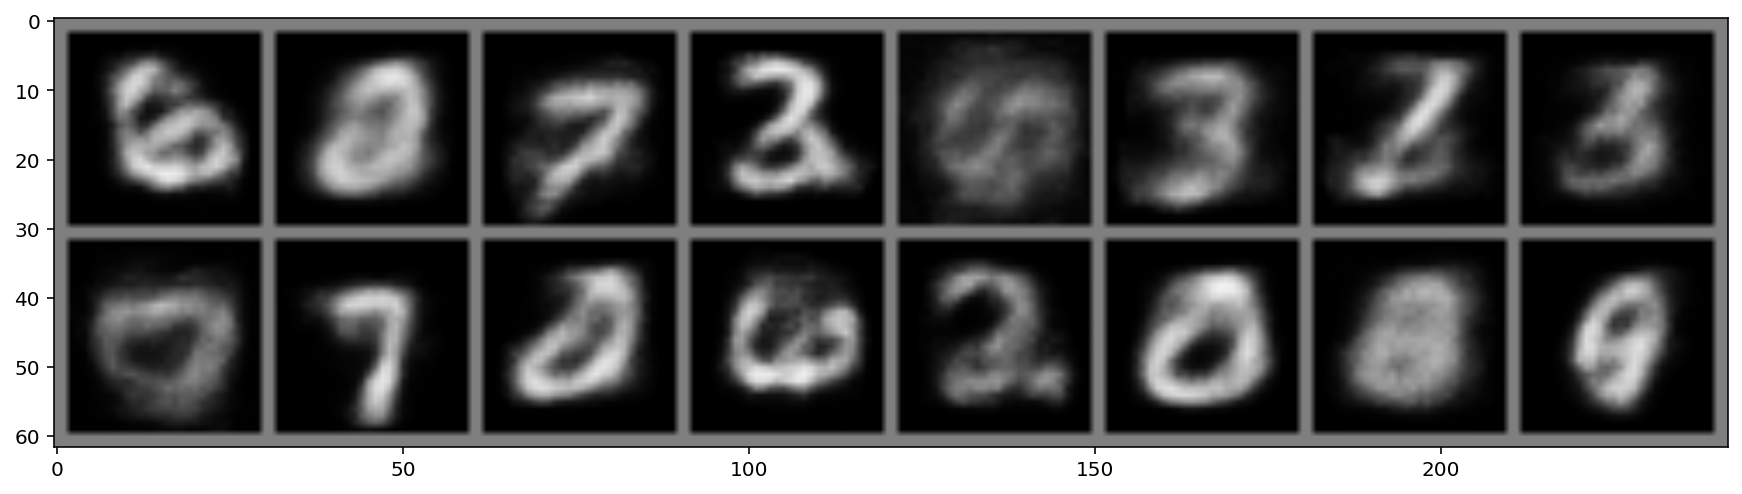

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:00<00:00,  4.81s/it]

Wall time: 4min


In [43]:
%%time

# Optimizer
params = [param for param in list(encoder.parameters()) + list(decoder.parameters()) ]
optimizer = optim.Adam(params, lr=lr)

epochs = []
fids = []
n_batch = 0
train_index = list(range(N))
for epoch in tqdm(range(num_epochs)):
    data = []
    fid = []
    np.random.shuffle(train_index)
    X_ = X_[train_index].cuda()
    for i in range(0, N, batch_size):
        X = X_[i:i+batch_size].reshape(expected_input_shape).float().cuda()
        
        optimizer.zero_grad()
        # Encode parameters of q
        mu_z, std_z = encoder(X)
        # sample from q(z|x)
        q = torch.distributions.Normal(mu_z, std_z)
        z = q.rsample().cuda()

   
        ####2 Reconstruction Error
        # Compute Likelihood 
        mu_x, std_x = decoder(z)
        # Compute the probability of x given xhat
        dist = torch.distributions.Normal(mu_x, std_x)
        log_pxz = dist.log_prob(X)
        # sum across channels, and all pixels (width, height)
        # this gives the log probability of THIS particular IMAGE
        log_pxz = log_pxz.sum(-1)#.sum(dim=sumdims)
        # this is the gaussian likelihood
        recon_loss = log_pxz


        #### KL Loss

        q = torch.distributions.Normal(mu_z, std_z)
        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # Since these are log probabilities
        # we can sum all the individual dimensions to give us the multi-dimensional
        # probability
        kl = (log_qzx - log_pz).sum(1) * 40 # this works well (see conclusion in the end of the notebook)
        elbo = (kl - recon_loss).sum()
        elbo.backward(retain_graph=True)
        optimizer.step()

        data += [{"elbo" : elbo.detach().item(),
                  "KL" : kl.detach().mean().item(),
                  "LL" : recon_loss.detach().mean().item()
                  }]
        
    epochs.append(pd.DataFrame(data).mean())
    print("End of Epoch %s" % epoch)
    with torch.no_grad():
        display.clear_output(True)
        #Z = q.rsample()
        Z = p.sample(batch_size)
        #Z = torch.randn(batch_size, latent_dim).cuda()
        mu_x, std_x = decoder(Z)
        #dist = torch.distributions.Normal(mu_x, 0)
        
        #sample = dist.rsample()
        sample = mu_x.reshape(batch_size,
                            input_shape[1],
                           input_shape[2],
                           input_shape[3])
        imshow(sample[:16])
        if eval_fid:
            # Compare with random sample from val
            real = V_[np.random.choice(list(range(V_.shape[0])), batch_size)]
            fid = FID2(real, sample, False)
            fids.append(fid)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

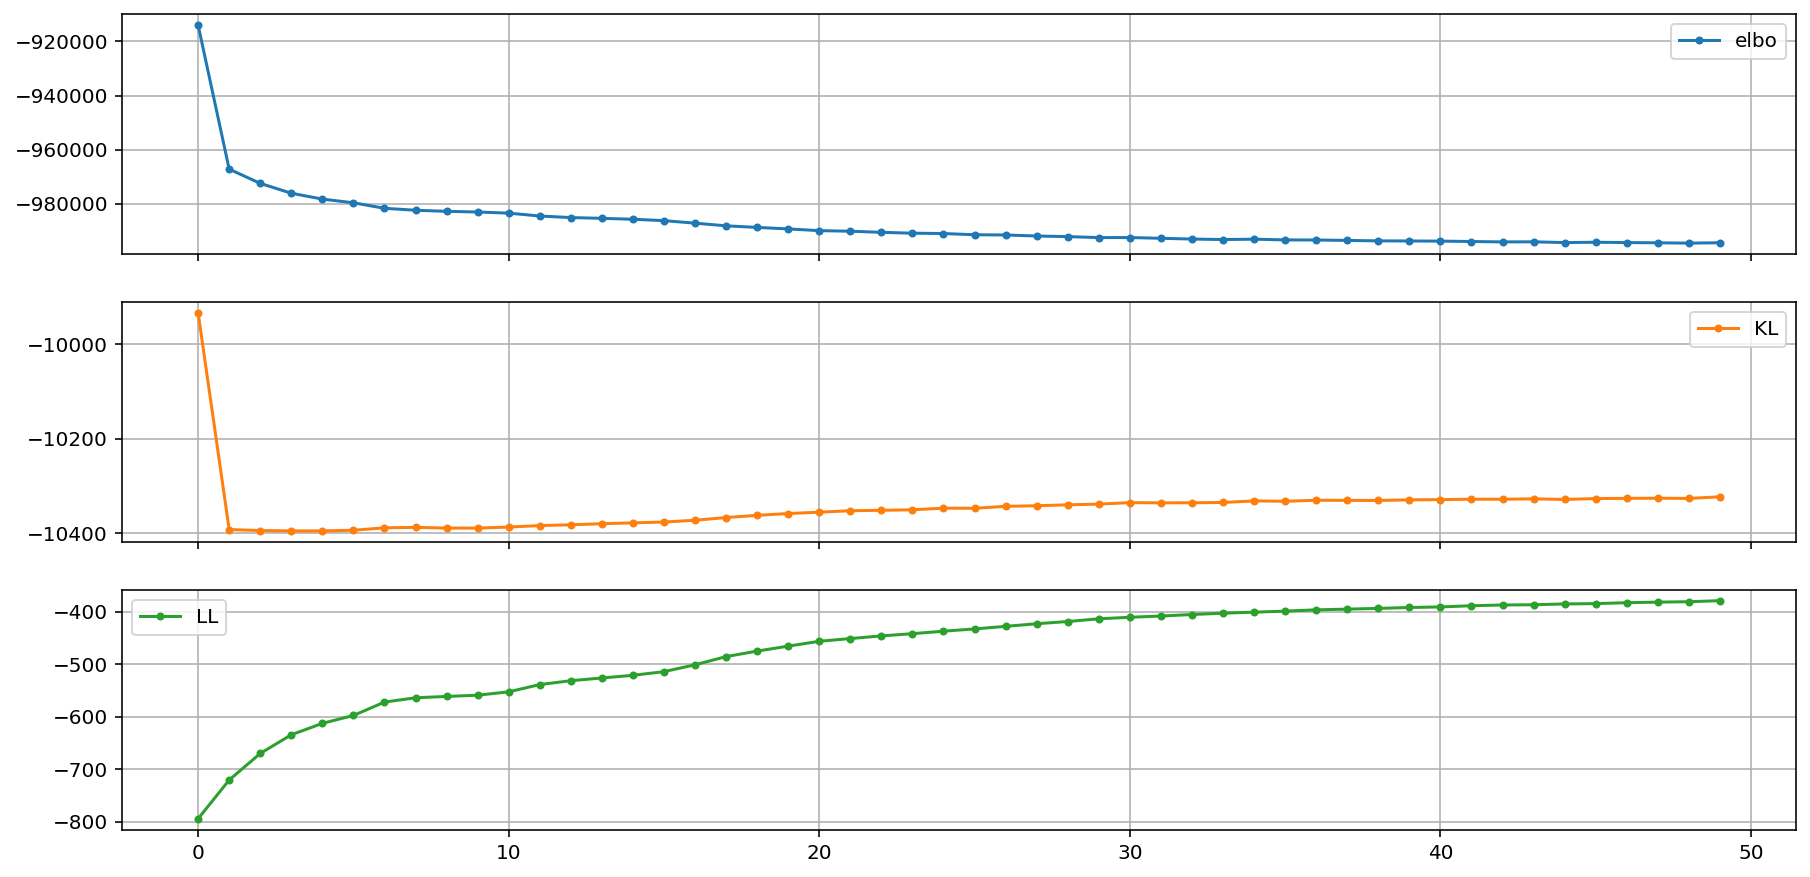

In [44]:
df = pd.DataFrame(epochs)
df["val_fid"] = fids if eval_fid else None
#df[["elbo","val_fid"]].plot(subplots=True, style=".-",grid=True)
df.plot(subplots=True, style=".-",grid=True)

## Example Images

Generating from p:

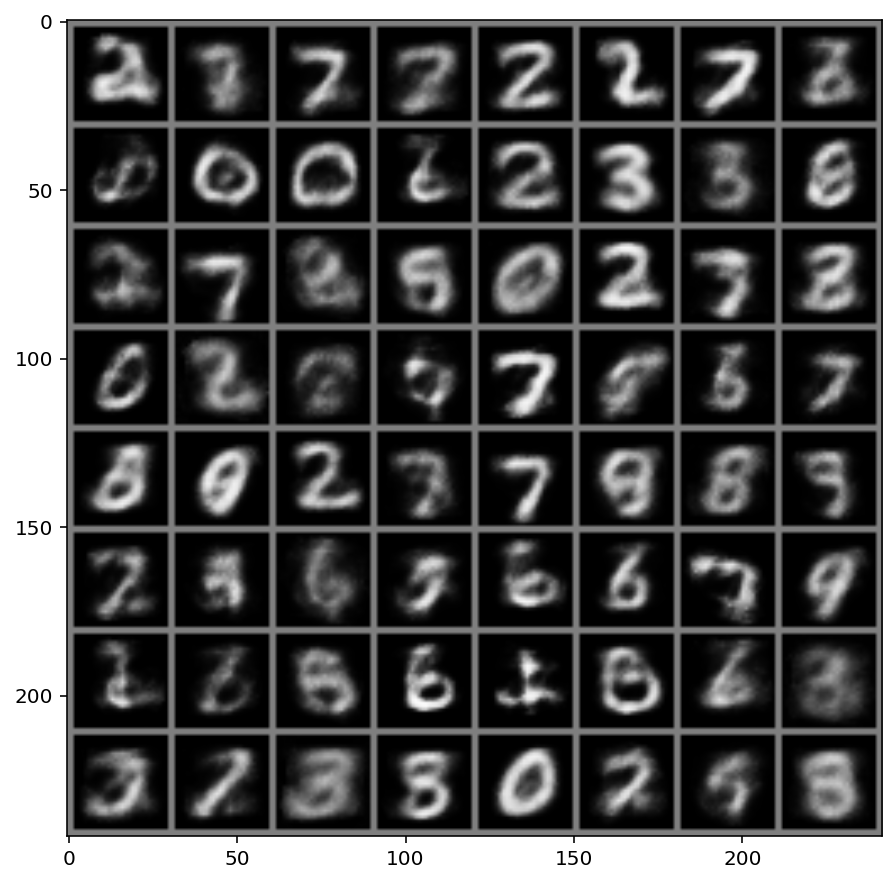

In [46]:
with torch.no_grad():
    s = 64
    Z = p.sample(s)
   

    Xhat, _ = decoder(Z)
    imgs = Xhat[:s].reshape(s,
                        input_shape[1],
                       input_shape[2],
                       input_shape[3])
    imshow(imgs)

Reconstructing from q:

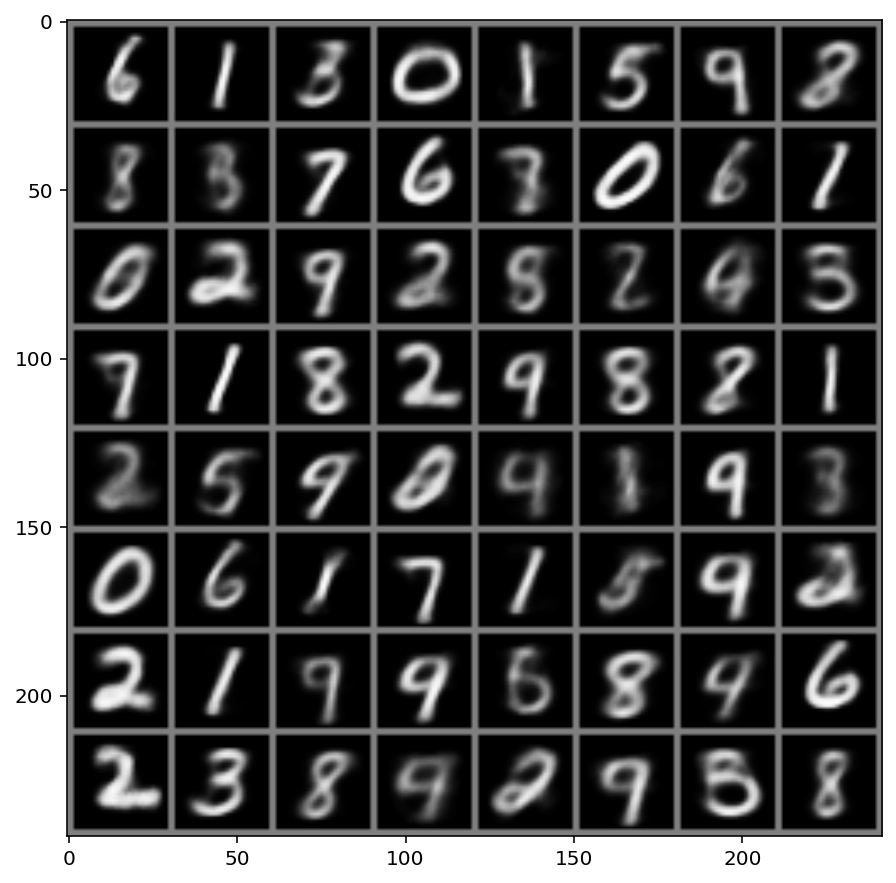

In [47]:
with torch.no_grad():
    s = 64
    Z = q.rsample()
    Xhat, _ = decoder(Z)
    imgs = Xhat[:s].reshape(s,
                        input_shape[1],
                       input_shape[2],
                       input_shape[3])
    imshow(imgs)

In [41]:
# Save model for inference
PATH = "mnist_NFP_decoder.pt"
torch.save(decoder, PATH)

## B) SVHN

In [55]:
dataset = {0 : "mnist", 1 : "svhn"}[1]
encoder_type = "dense"
eval_fid = False
latent_dim = D = 50
M = 277
lr = 0.00025
batch_size = 100
num_epochs = 50
input_shape = {"mnist" : (batch_size, 1,28,28),
               "svhn"  : (batch_size, 3,32,32)}[dataset]
expected_input_shape = (input_shape[0],
                        input_shape[1] * input_shape[2] * input_shape[3])

# parameter approximator for q(z|x)
encoder = Encoder(expected_input_shape[-1], M, latent_dim).cuda()
# parameter approximator for p(x|z)
decoder = Decoder(latent_dim, M, expected_input_shape[-1]).cuda()
# prior p(z|x)
num_flows = 2
nets = lambda: nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                             nn.Linear(M, M), nn.LeakyReLU(),
                             nn.Linear(M, D // 2), nn.Tanh())

nett = lambda: nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                             nn.Linear(M, M), nn.LeakyReLU(),
                             nn.Linear(M, D // 2))

p = FlowPrior(nets, nett, num_flows, D).cuda()

In [49]:
n_params(encoder) + n_params(decoder) + n_params(p)

2265809

In [50]:
X_, V_ = load_data(dataset, test=False, val_frac = .1)
N = X_.shape[0]
if N%batch_size:
    N = N - N%batch_size

Using downloaded and verified file: ./SVHN/dataset\train_32x32.mat


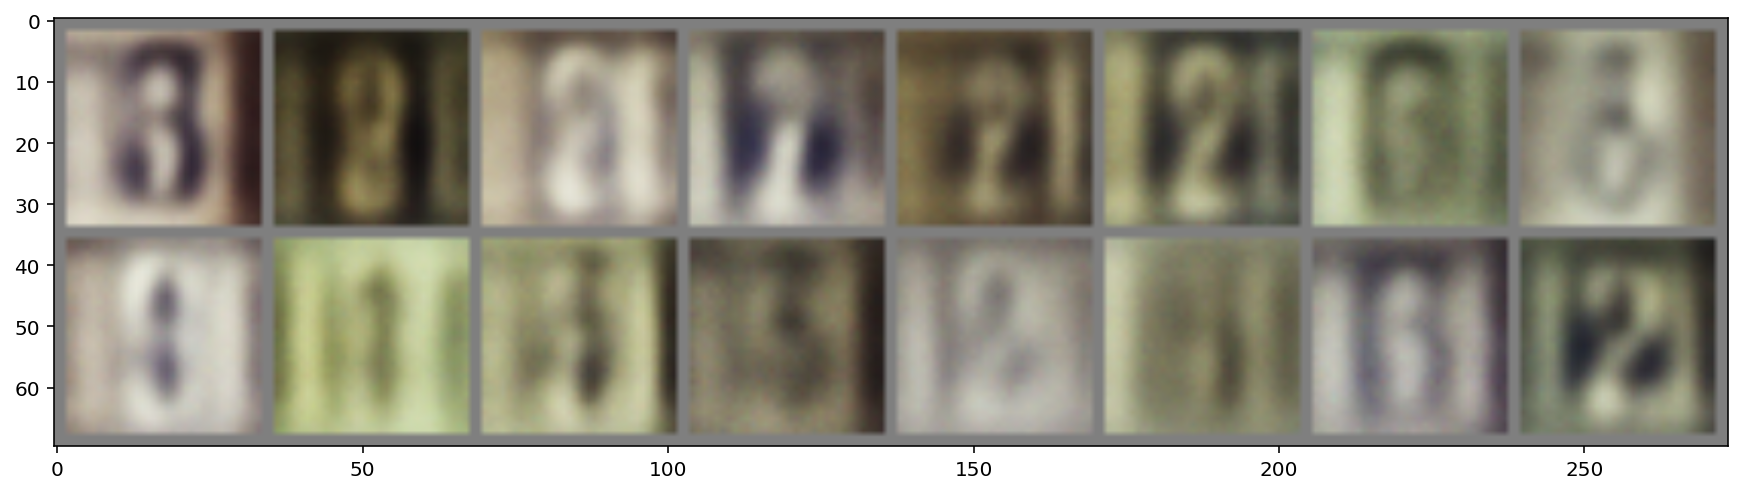

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:12<00:00,  6.25s/it]

Wall time: 5min 12s


In [56]:
%%time

# Optimizer
params = [param for param in list(encoder.parameters()) + list(decoder.parameters()) ]
optimizer = optim.Adam(params, lr=lr)

epochs = []
fids = []
n_batch = 0
train_index = list(range(N))
for epoch in tqdm(range(num_epochs)):
    data = []
    fid = []
    np.random.shuffle(train_index)
    X_ = X_[train_index].cuda()
    for i in range(0, N, batch_size):
        X = X_[i:i+batch_size].reshape(expected_input_shape).float().cuda()
        
        optimizer.zero_grad()
        # Encode parameters of q
        mu_z, std_z = encoder(X)
        # sample from q(z|x)
        q = torch.distributions.Normal(mu_z, std_z)
        z = q.rsample().cuda()

   
        ####2 Reconstruction Error
        # Compute Likelihood 
        mu_x, std_x = decoder(z)
        # Compute the probability of x given xhat
        dist = torch.distributions.Normal(mu_x, std_x)
        log_pxz = dist.log_prob(X)
        # sum across channels, and all pixels (width, height)
        # this gives the log probability of THIS particular IMAGE
        log_pxz = log_pxz.sum(-1)#.sum(dim=sumdims)

        recon_loss = log_pxz


        #### KL Loss

        q = torch.distributions.Normal(mu_z, std_z)
        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # Since these are log probabilities
        # we can sum all the individual dimensions to give us the multi-dimensional
        # probability
        kl = (log_qzx - log_pz).sum(1) * 40 # this works well (see conclusion in the end of the notebook
        elbo = (kl - recon_loss).sum()
        elbo.backward()
        optimizer.step()

        data += [{"elbo" : elbo.detach().item(),
                  "KL" : kl.detach().mean().item(),
                  "LL" : recon_loss.detach().mean().item()
                  }]
        
    epochs.append(pd.DataFrame(data).mean())
    print("End of Epoch %s" % epoch)
    with torch.no_grad():
        display.clear_output(True)
        #Z = q.rsample()
        Z = p.sample(batch_size)
        #Z = torch.randn(batch_size, latent_dim).cuda()
        mu_x, std_x = decoder(Z)
        #dist = torch.distributions.Normal(mu_x, 0)
        
        #sample = dist.rsample()
        sample = mu_x.reshape(batch_size,
                            input_shape[1],
                           input_shape[2],
                           input_shape[3])
        imshow(sample[:16])
        if eval_fid:
            # Compare with random sample from val
            real = V_[np.random.choice(list(range(V_.shape[0])), batch_size)]
            fid = FID2(real, sample, False)
            fids.append(fid)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

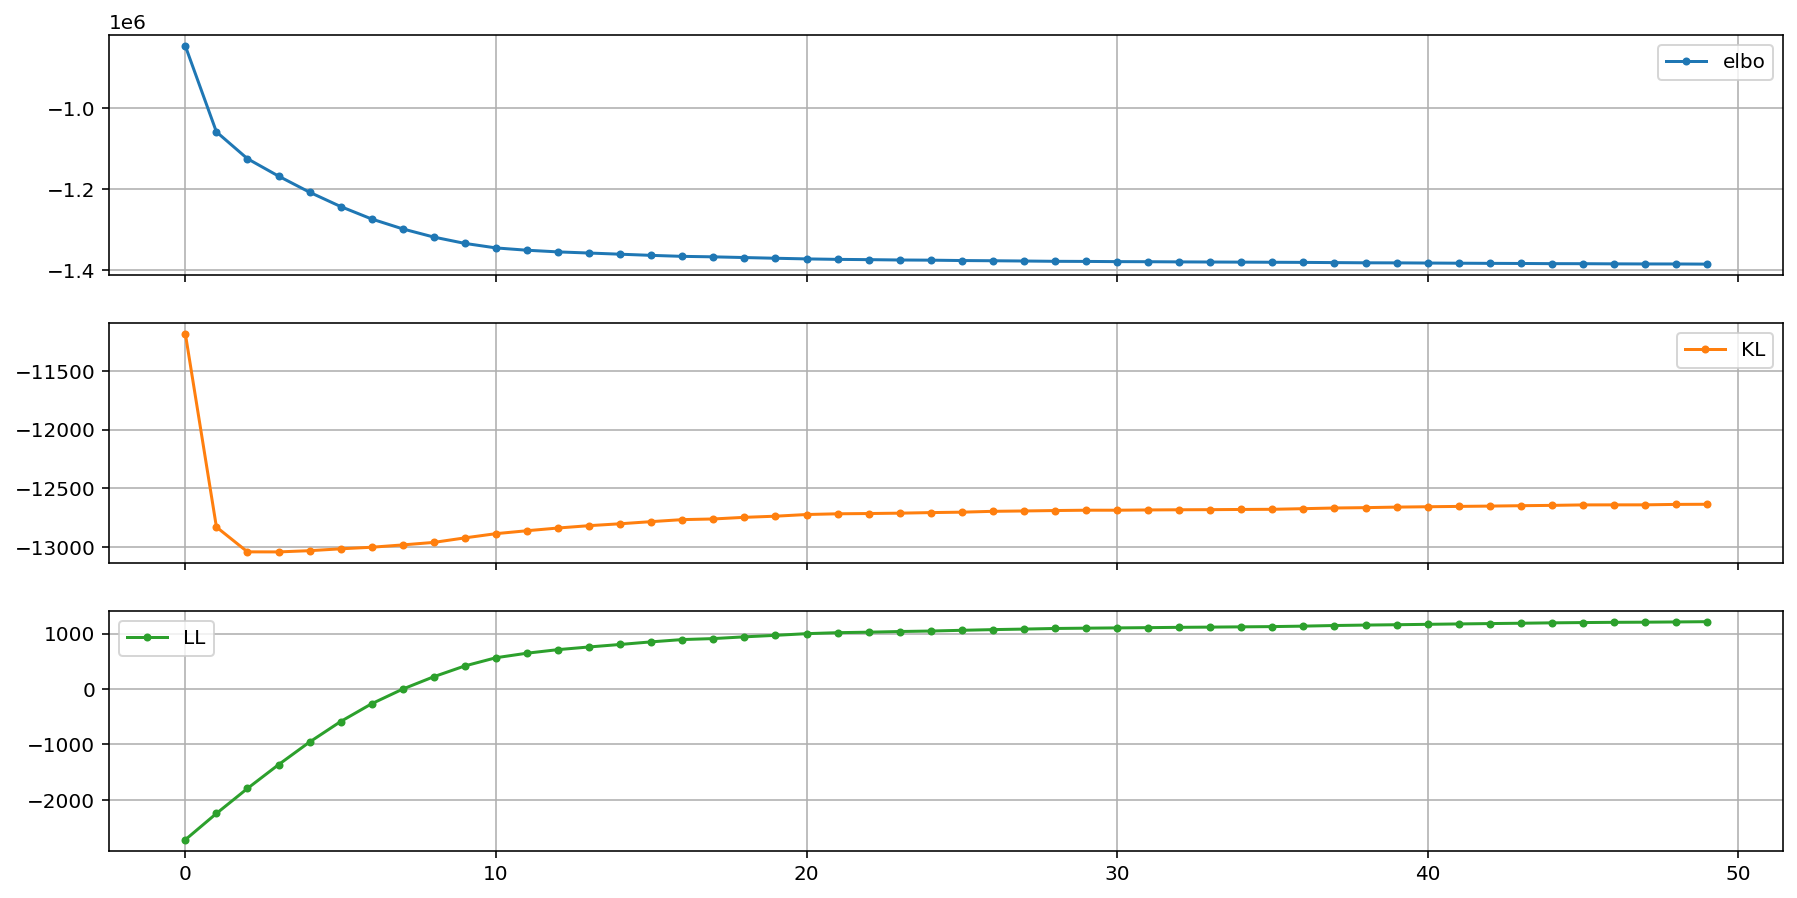

In [63]:
df = pd.DataFrame(epochs)
df["val_fid"] = fids if eval_fid else None
#df[["elbo","val_fid"]].plot(subplots=True, style=".-",grid=True)
df.plot(subplots=True, style=".-",grid=True)

## Example Images

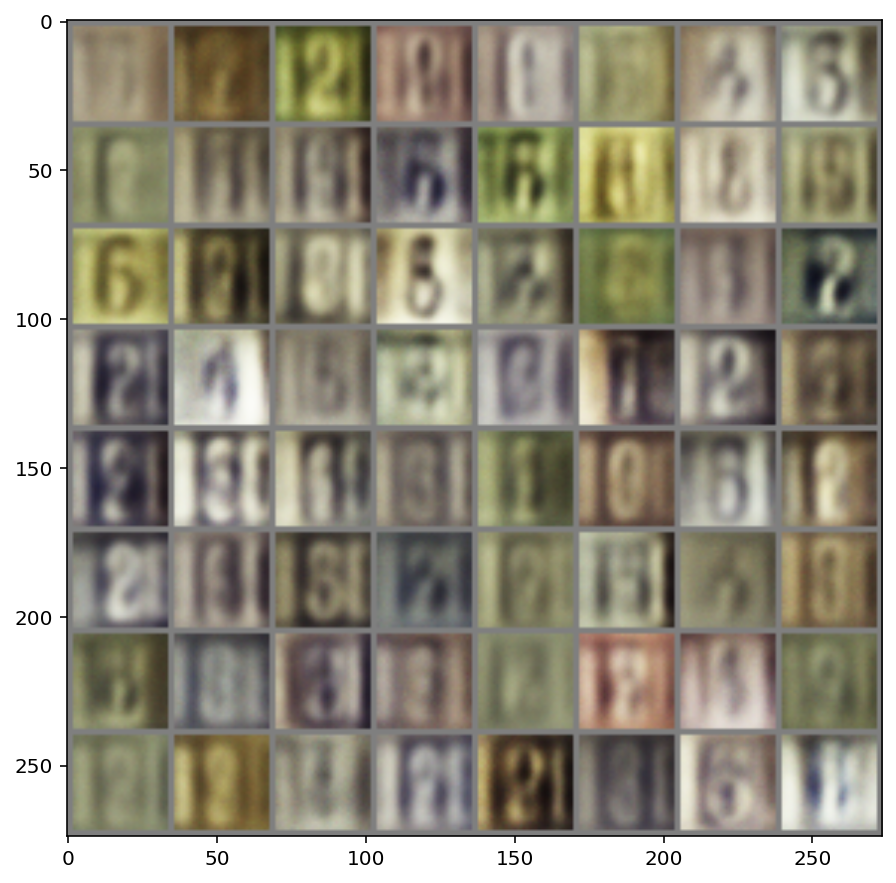

In [68]:
with torch.no_grad():
    s = 64
    Z = p.sample(s)
    Xhat, _ = decoder(Z)
    imgs = Xhat[:s].reshape(s,
                        input_shape[1],
                       input_shape[2],
                       input_shape[3])
    imshow(imgs)

In [69]:
# Save model for inference
PATH = "svhn_NFP_decoder.pt"
torch.save(decoder, PATH)

## Conclusive Note on training the VAE + NFP
When training in general we could often see that the implementation is not working the way we anticipated. The model seems to be focusing on reconstructing the error, without targeting the KL term, which is even decreasing over time. This will result in poor generative capabilities. This issue can be partly solved by scaling the KL term in the objective, but the overall issue is more likely related to our implementation.


Training the VAE + NFP is not as stable as using the vanilla prior. Although the training behaviour is relatively similar to the normal VAE, its additional parameter set induced by the flow nets does not only bring more flexibility but most likely also additional training problems.

# 